# Prophet template

For time series data analysis using Facebook's prophet library.

In [5]:
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [6]:
import os, sys

In [7]:
from typing import List

In [8]:
import pandas as pd

In [41]:
import matplotlib.pyplot as plt

## Data loading

In [9]:
DATA_FOLDER = "../data"

In [10]:
# data_file = os.path.join(DATA_FOLDER, "input_data_anonymized.csv")
data_file = os.path.join(DATA_FOLDER, "input_data_dont_send.csv")

In [31]:
assert os.path.exists(data_file), f"Data file {data_file} does not exist"

### Columns

In [17]:
# The actual time series we're trying to predict
# target_column : str = 'var1'
target_column : str = None

# The column holding the timestamp
# dt_column : str = 'dt'
dt_column : str = None

# Other covariates
# covariate_columns : List = ['var2', 'var3']
covariate_columns : List = None


In [27]:
# Make sure values have been explicitly set
assert target_column is not None
assert dt_column is not None
assert covariate_columns is not None

In [18]:
# Read file and parse data column
df_full = pd.read_csv(data_file, parse_dates=[dt_column])

In [19]:
# Set the timestamp index
df_full = df_full.set_index(dt_column, drop=False)

In [20]:
# Columns must be renamed in order to use prophet
# The target variable must be called 'y', and the timestamp must be called 'ds'
df_full.rename(mapper={target_column: 'y', dt_column: 'ds'}, axis=1, inplace=True)

### Plot data

Automatically plot also covariates, if they are less than 5

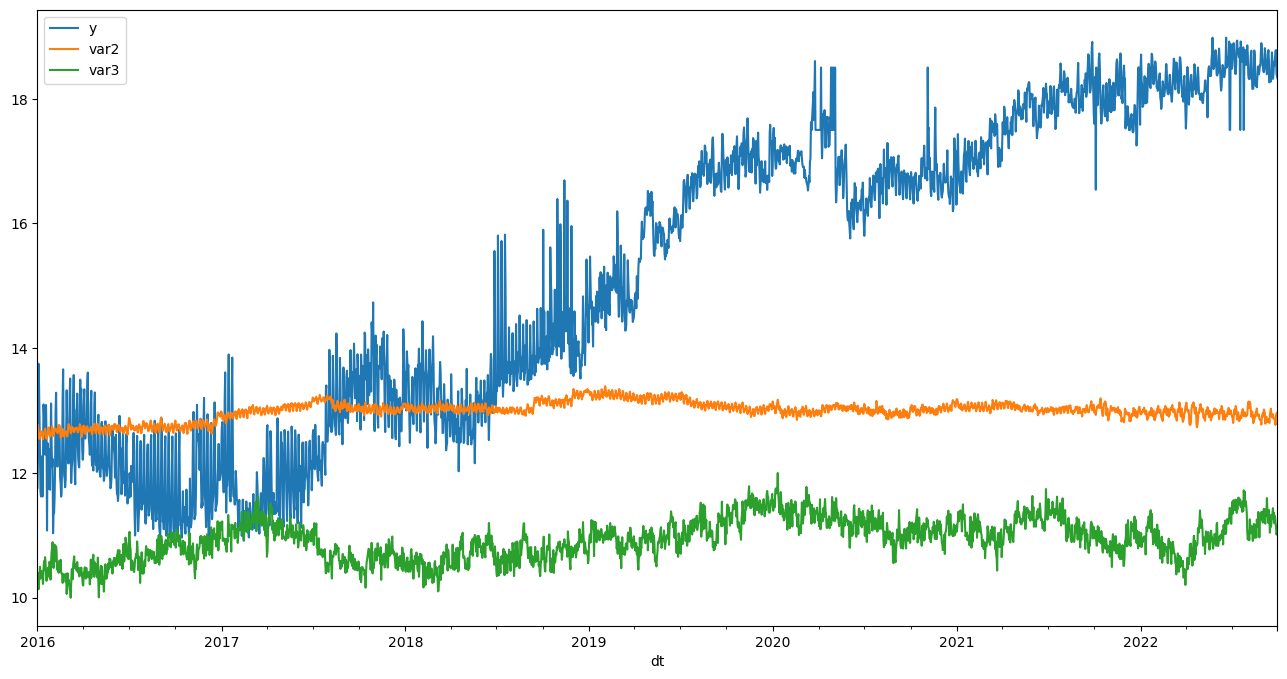

In [23]:
if len(covariate_columns) < 5:
    df_full[['y'] + covariate_columns].plot(figsize=(16, 8));
else:
    df_full['y'].plot(figsize=(16, 8));

In [24]:
# Uncomment this line to plot all covariates anyway
# df_full[['y'] + covariate_columns].plot(figsize=(16, 8));

## Helper functions

In [56]:
from sklearn.metrics import r2_score, mean_squared_error

In [53]:
def regression_report(y_test, y_test_hat):
    print("Test: ")
    print(f"R2 score: {r2_score(y_test, y_test_hat)}")
    print(f"MSE: {mean_squared_error(y_test, y_test_hat)}")
    

### Manually select training and test range

In [32]:
# Skip data from before 2020, as it is no longer representative
train_from = '2020-01-01'
train_to = '2022-08-31'
test_from = '2022-09-01'
test_to = '2022-09-30'

### Create model

In [33]:
model = Prophet(growth='linear',
    seasonality_mode= 'multiplicative',
    weekly_seasonality=True,
    yearly_seasonality=False,
    holidays_prior_scale=20,
    seasonality_prior_scale = 0.005,
               )
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.add_seasonality(name='weekly', period=7, fourier_order=50)
model.add_country_holidays(country_name='SWE')
model.add_regressor('var2')

In [34]:
model.fit(df_full[train_from:train_to])

16:35:06 - cmdstanpy - INFO - Chain [1] start processing
16:35:06 - cmdstanpy - INFO - Chain [1] done processing


In [39]:
N_periods_to_predict = 30

In [49]:
# If no covariates exist, must create dataframe for future predictions.
# If there are some, we assume they are in the original dataframe
if not covariate_columns:
    future = model.make_future_dataframe(N_periods_to_predict)
else:
    future = df_full[test_from:test_to].copy()

In [50]:
forecast = model.predict(future)

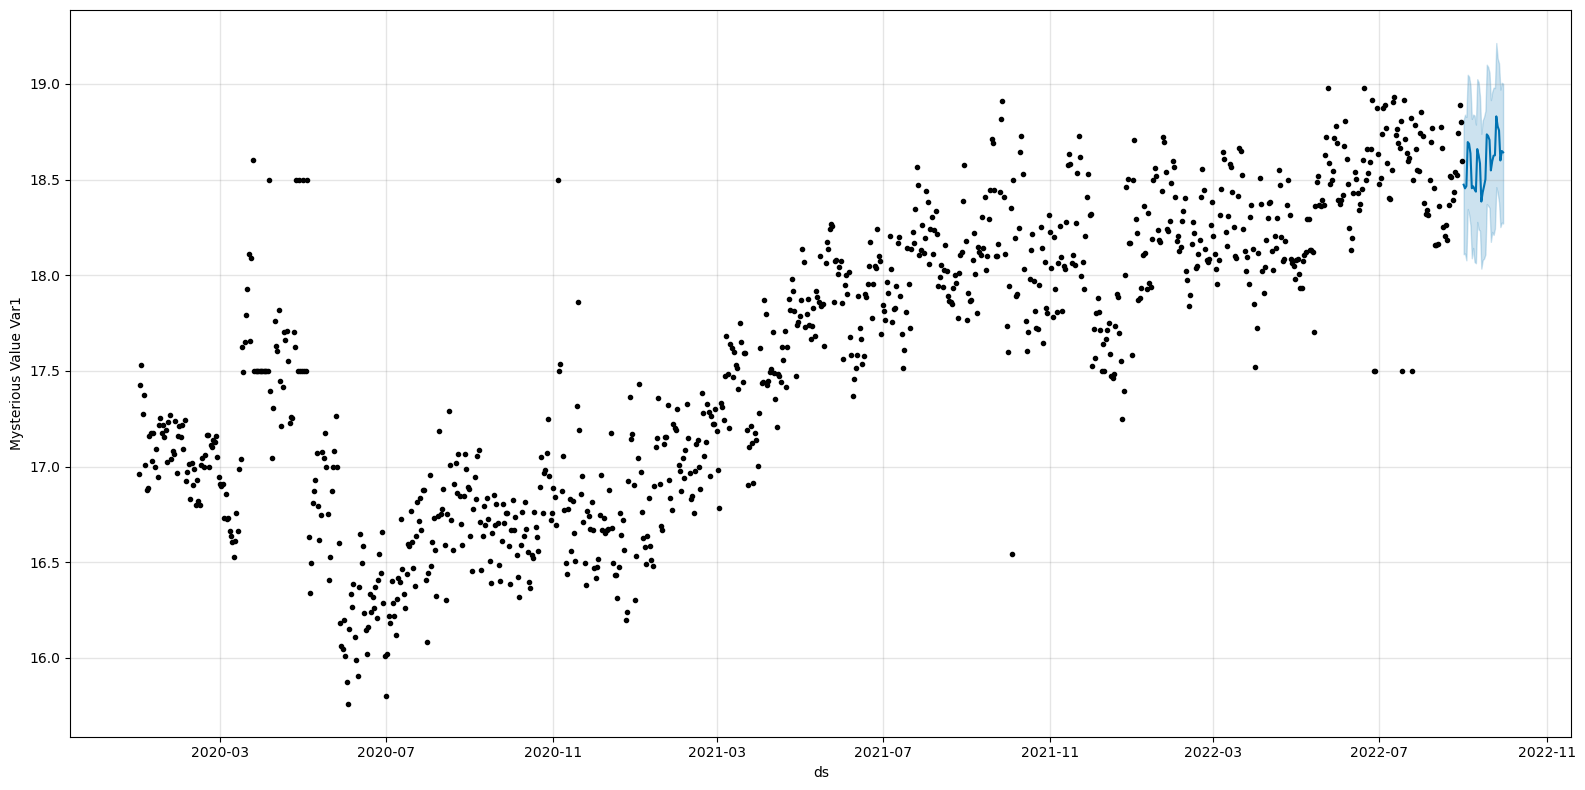

In [51]:
# Forecast
# forecast = model.predict(future)
 
#Plot Forecast
fig, ax = plt.subplots(figsize=(16, 8))
model.plot(forecast, ax = ax)
ax.set_ylabel('Mysterious Value Var1');

In [57]:
regression_report(df_full[test_from:test_to]['y'], forecast['yhat'])

Test: 
R2 score: 0.251660049426251
MSE: 0.019108332346637853


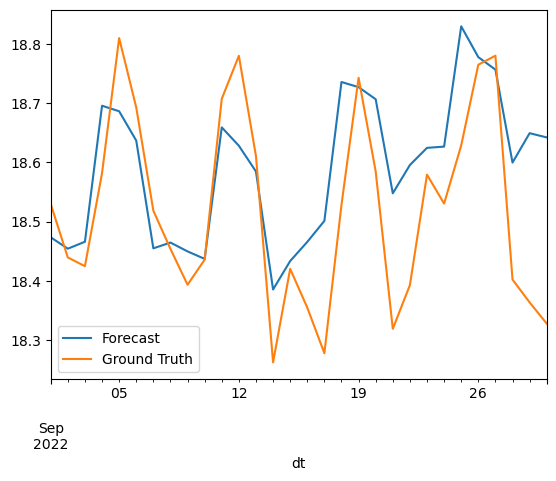

In [60]:
ax = forecast.set_index('ds')['yhat'].plot()
df_full[test_from:test_to]['y'].plot(ax=ax)
ax.legend(['Forecast', 'Ground Truth'])